In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import requests, json
import matplotlib
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [31]:
class Sailboat():
    def __init__(self):
        self.data = None
        self.variable_to_column_name = {
                'o2 concentration': 'O2 Concentration [micromolar]',
                'o2 saturation': 'O2 Saturation [%]',
                'bb470': 'Bb(470) [NTU]',
                'bb532': 'Bb(532) [NTU]',
                'bb650': 'Bb(650) [NTU]',
                'cdom': 'CDOM [QSU]',
                'chla': 'Chl. a [ppb]',
                'phycocyanin': 'Phycocyanin [ppb]' 
            }
        self.color = None
    
    def api_download(self, date_interval, variables):
        """
        Download sailboat dataset with the given date interval and variables 
        """
        self.data = None 
        
    def str_to_float(self, variable):
        variable_column = self.variable_to_column_name[variable]
        self.data[variable_column].replace(',', np.nan, inplace=True)
        self.data[variable_column] = list(map(lambda x: float(x),
                                             self.data[variable_column]))
    
    def plot(self, x_variable, y_variable,
            xlim=None, ylim=None, x_fontsize=20, y_fontsize=20, p_size=5, 
             jet_convert=False, show_z=False, z='bb470', vmin=0, vmax=200, ax = None):
                
        if ax is None:
            fig = plt.figure(figsize=(10, 10))
            ax = plt.axes(projection=request.crs)
            
        self.str_to_float(x_variable)
        self.str_to_float(y_variable)
        x_column = self.variable_to_column_name[x_variable]
        y_column = self.variable_to_column_name[y_variable]
            
        if jet_convert:
            for bb in ['bb470', 'bb532', 'bb650']:
                self.str_to_float(bb)
                
            three_color_bb = np.array(self.data[['Bb(650) [NTU]', 'Bb(532) [NTU]', 'Bb(470) [NTU]']])
            row_sum = np.sum(three_color_bb, axis=1).reshape(len(three_color_bb),1)
            three_color_bb = three_color_bb/row_sum
            red = three_color_bb[:, 0]
            blue = three_color_bb[:, 2]
            scheme_percent = 0.5 + red*0.5 - blue*0.5
            self.color = [cm.jet(x) for x in scheme_percent]
            ax.scatter(self.data[x_column], self.data[y_column], s=p_size,
                        c=self.color, alpha=0.5)
        #else:
        #    plt.scatter(self.data[x_column], self.data[y_column], s=p_size)
        
        if show_z: 
            self.str_to_float(z)
            z_column_name = self.variable_to_column_name[z]
            self.color = self.data[z_column_name]
#             plt.figure(figsize=(12,10))
            ax.scatter(self.data[x_column], self.data[y_column], s=p_size,
                c=self.color, alpha=0.5, vmin=vmin, vmax=vmax, cmap='jet')
            fig.colorbar(label=z_column_name)
        else:
#             plt.figure(figsize=(10,10))
            ax.scatter(self.data[x_column], self.data[y_column], s=p_size)
            
        ax.set_xlabel(x_column, fontsize=x_fontsize)
        ax.set_ylabel(y_column, fontsize=y_fontsize)
        if xlim != None:
            ax.set_xlim(xlim)
        if ylim != None:
            ax.set_ylim(ylim)
#         plt.show()
        
    def background(self, extent = [-81.15, -80.51,26.65, 27.24], ax=None, 
                  request = cimgt.GoogleTiles(style='satellite'),
                 out = False):
        
        if ax is None:
            fig = plt.figure(figsize=(10, 10))
            ax = plt.axes(projection=request.crs)
        gl = ax.gridlines(draw_labels=True, alpha=0.2)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

        ax.set_extent(extent)

        if request:
            ax.add_image(request, 10)
        if out is True:
            return fig, ax

    def plot_path(self, var, start_date, end_date, s=10):
        self.str_to_float(var)
        fig = plt.figure(figsize=(10, 10))
        ax = plt.axes(projection=cimgt.GoogleTiles(style='satellite').crs)
        self.background(ax=ax)
        var_column_name = self.variable_to_column_name[var]
#         plt.figure(figsize=(10, 10))
#         plt.axes(projection=cimgt.GoogleTiles(style='satellite').crs)
        start_date_val = datetime.strptime(start_date, '%Y-%m-%d')
        end_date_val = datetime.strptime(end_date, '%Y-%m-%d')
        select_rows = (self.data['GPSTimeStamp']>=start_date_val)&(self.data['GPSTimeStamp']<=end_date_val)
        df = self.data.loc[select_rows, :]
        mask = (df['Lon']<-10) & (df['Lat']>10)

#         df['Lon'][df['Lon']>-10] = np.nan
#         df['Lat'][df['Lat']<10] = np.nan
        #df[var_column_name][df[var_column_name]<0] = np.nan
        #ax.scatter(df['Lon'], df['Lat'], c=df[var_column_name], s=s, transform=ccrs.PlateCarree())
        #fig.colorbar(ax, label=var_column_name)
        #ax.set_title(f'{var} from {start_date} to {end_date}')
        mapp = ax.scatter(df['Lon'].loc[mask], df['Lat'].loc[mask],
                          c=df[var_column_name].loc[mask], s=s, transform=ccrs.PlateCarree())
        fig.colorbar(mapp, label=var_column_name)
#         fig.set_title(f'{var} from {start_date} to {end_date}')
        
    def plot_path_2(self, var, start_date, end_date, s=10):
        plt.figure(figsize=(10, 10))
        #ax = plt.axes(projection=cimgt.GoogleTiles(style='satellite').crs)
        start_date = datetime.strptime(start_date, '%Y-%m-%d')
        end_date = datetime.strptime(end_date, '%Y-%m-%d')
        select_rows = (self.data['GPSTimeStamp']>=start_date)&(self.data['GPSTimeStamp']<=end_date)
        df = self.data.loc[select_rows, :]
        df['Lon'][df['Lon']>-10] = np.nan
        df['Lat'][df['Lat']<10] = np.nan
        var_column_name = self.variable_to_column_name[var]
        plt.scatter(df['Lon'], df['Lat'], s=s)
        
    def clean_date(self):
        self.data['GPSTimeStamp'].replace('0000-00-00 00:00:00', '1900-01-01 12:12:12', inplace=True)
        array = []
        for x in self.data['GPSTimeStamp']:
            try:
                datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
                array.append(datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
            except ValueError:
                array.append(datetime.strptime('1900-01-01 12:12:12', '%Y-%m-%d %H:%M:%S'))
        self.data['GPSTimeStamp'] = array       
        self.data.sort_values(by='GPSTimeStamp', inplace=True)

In [32]:
# import os 
# all_df = []
# for filename in os.listdir('Data'):
#     if filename[0] != '.':
#         df = pd.read_csv(f"Data/{filename}", sep=', ')
#         all_df.append(df)

/Users/hboi/miniconda3/envs/owl/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


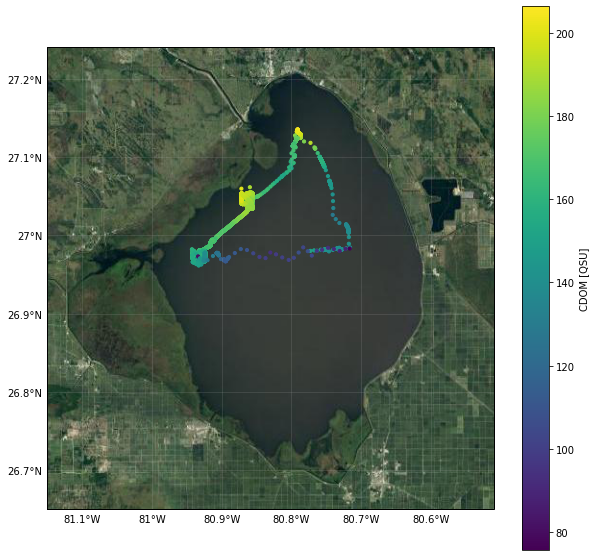

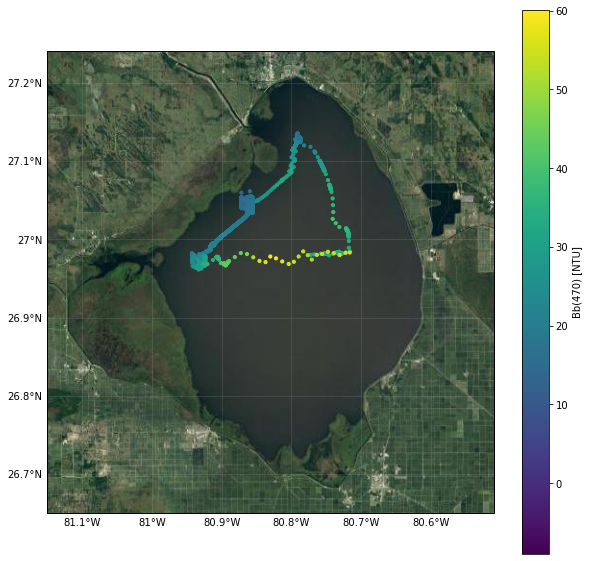

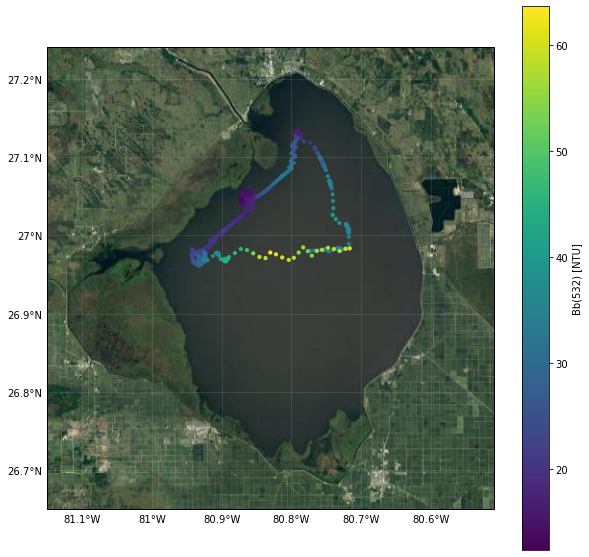

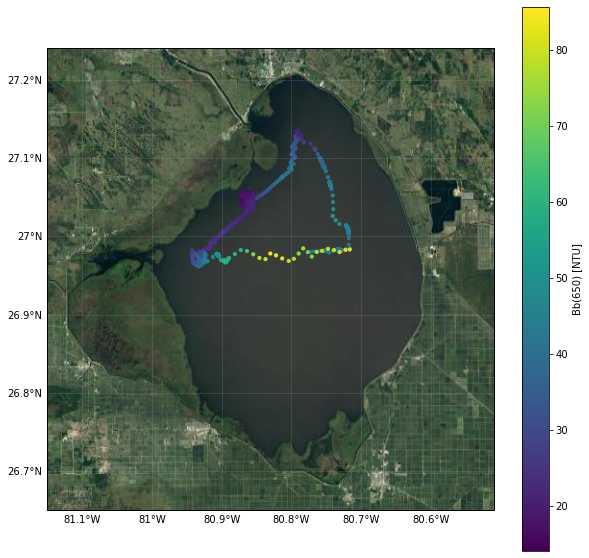

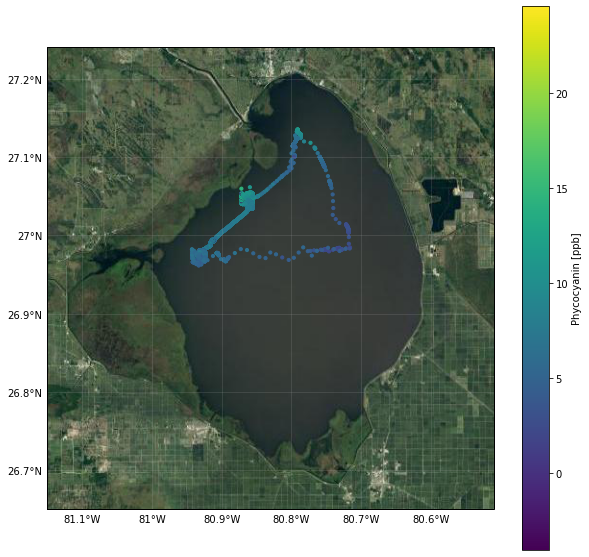

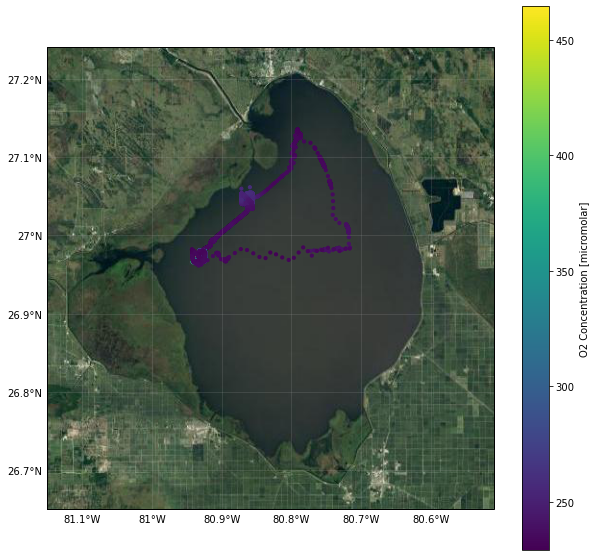

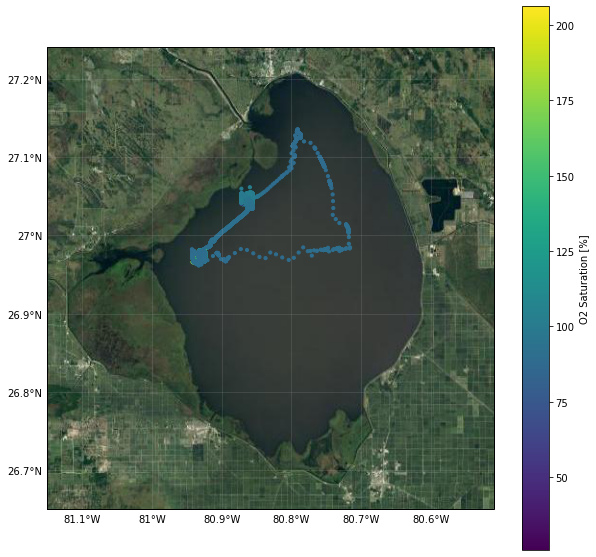

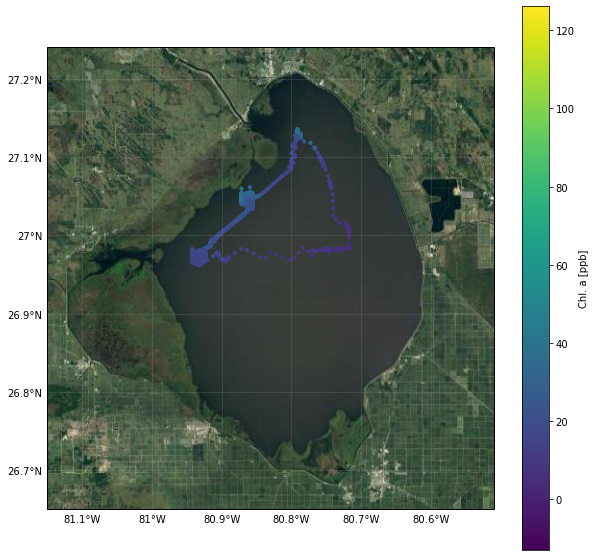

In [33]:
sailboat = Sailboat()
sailboat.data = pd.concat(all_df, ignore_index=True)
sailboat.clean_date()
for var in ['cdom', 'bb470', 'bb532', 'bb650', 'phycocyanin', 'o2 concentration', 'o2 saturation', 'chla']:
    sailboat.plot_path(var=var, start_date='2021-03-01', end_date='2021-03-04')

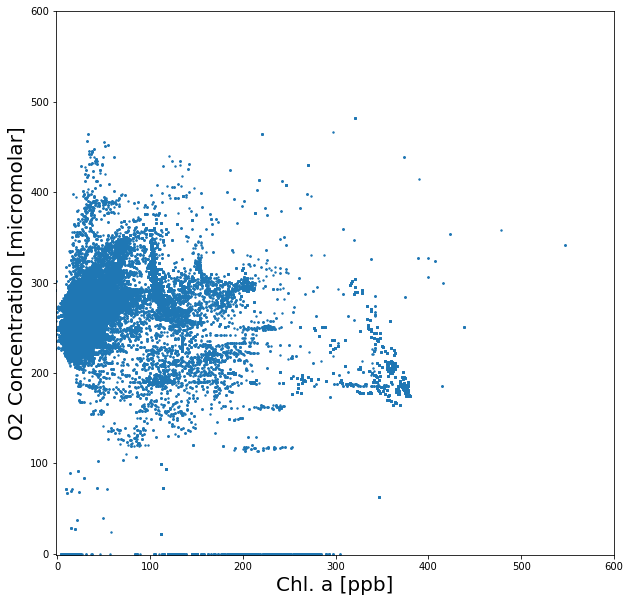

In [7]:
sailboat = Sailboat()
sailboat.data = pd.concat(all_df, ignore_index=True)
sailboat.plot(x_variable='chla', y_variable='o2 concentration',
             xlim=(-1,600), ylim=(-1,600), p_size=2)

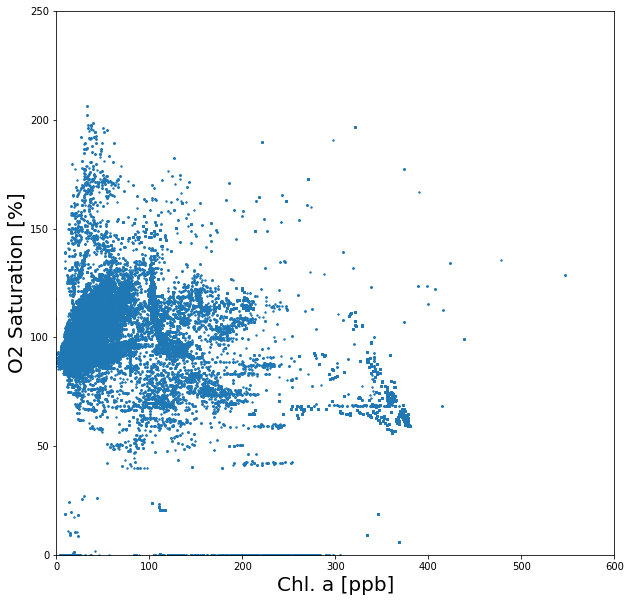

In [8]:
sailboat.plot(x_variable='chla', y_variable='o2 saturation',
             xlim=(0,600), ylim=(0,250), p_size=2)

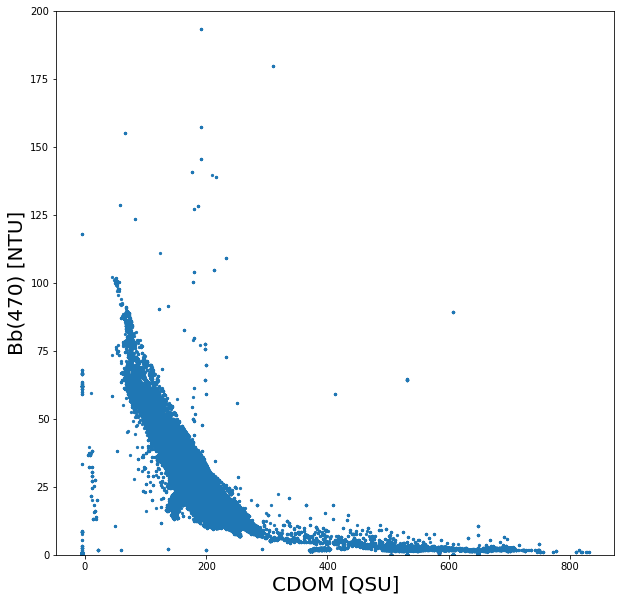

In [9]:
sailboat.plot(x_variable='cdom', y_variable='bb470',
             ylim=(0,200), p_size=5)

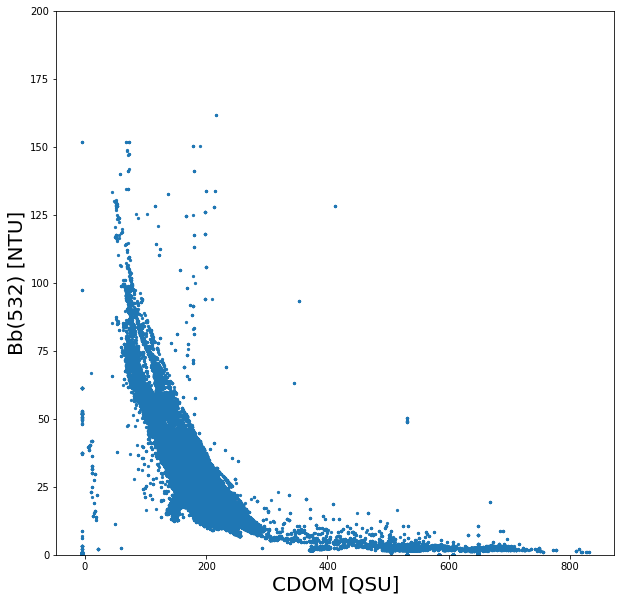

In [10]:
sailboat.plot(x_variable='cdom', y_variable='bb532',
             ylim=(0,200), p_size=5)

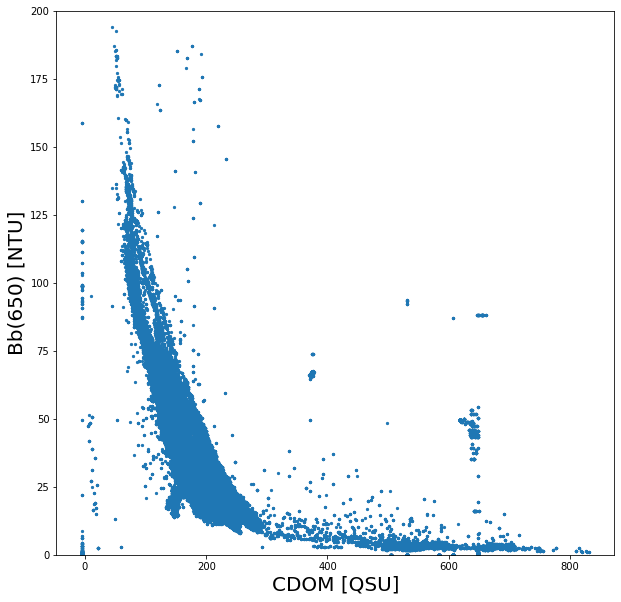

In [11]:
sailboat.plot(x_variable='cdom', y_variable='bb650',
             ylim=(0,200), p_size=5)

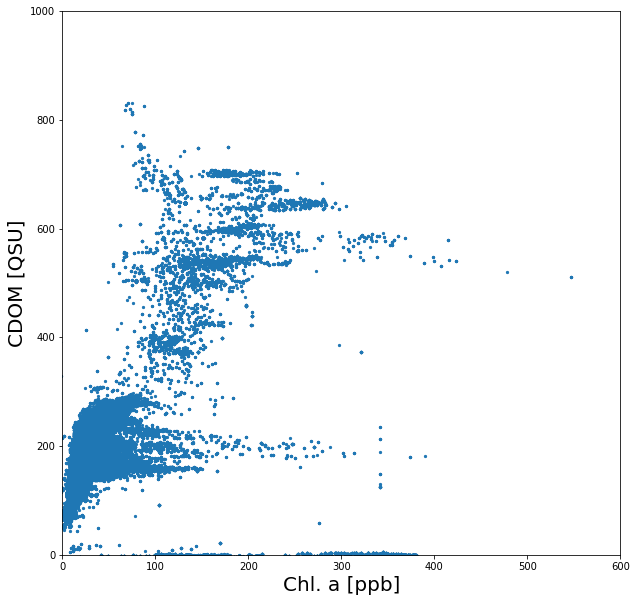

In [12]:
sailboat.plot(x_variable='chla', y_variable='cdom',
             xlim=(0,600), ylim=(0,1000), p_size=5)

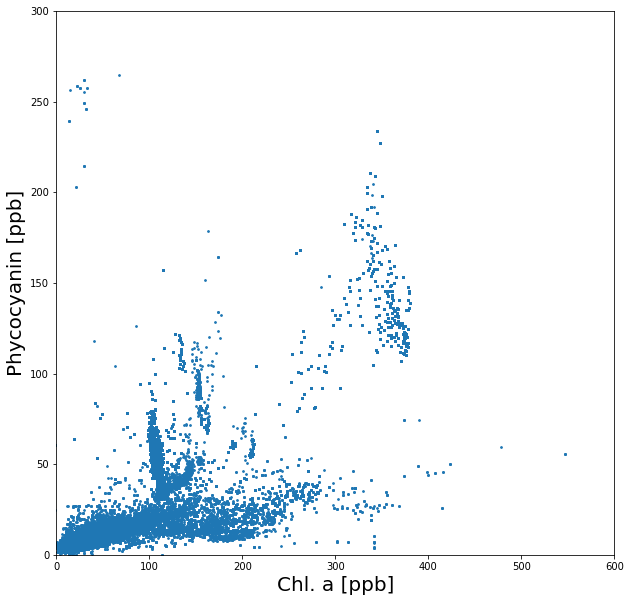

In [13]:
sailboat.plot(x_variable='chla', y_variable='phycocyanin',
             xlim=(0,600), ylim=(0,300), p_size=3)

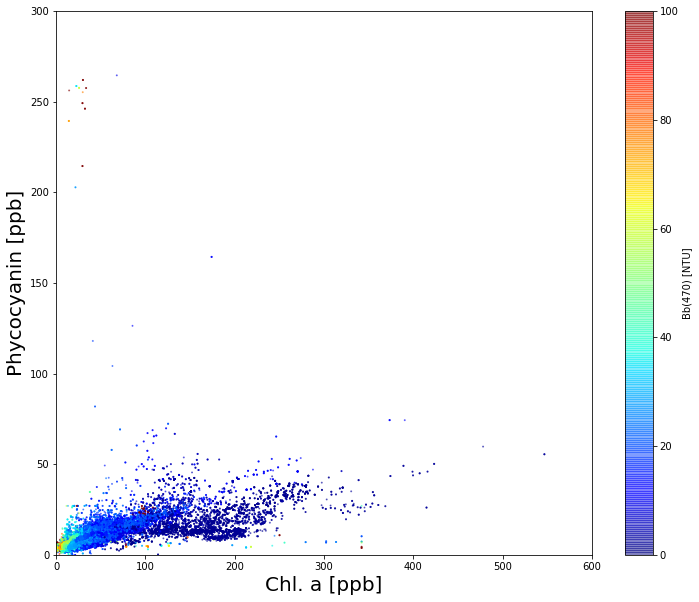

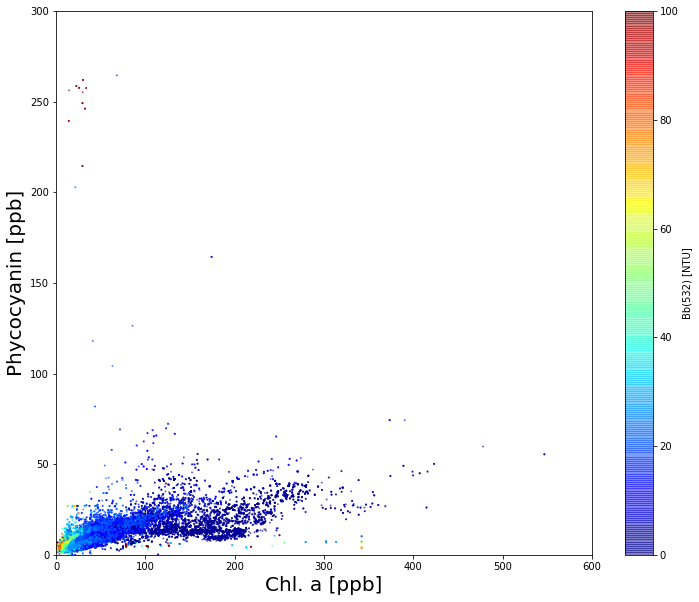

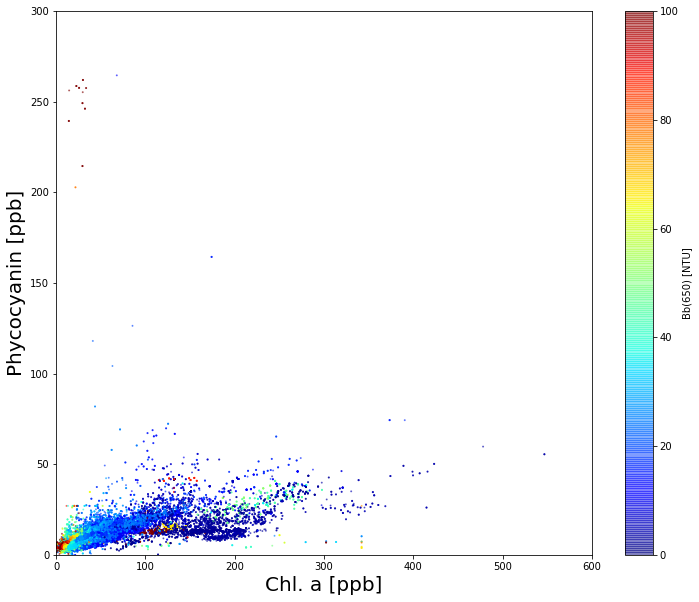

In [14]:
sailboat = Sailboat()
sailboat.data = pd.concat(all_df, ignore_index=True)
for bb in ['bb470', 'bb532', 'bb650']:
    sailboat.plot(x_variable='chla', y_variable='phycocyanin',
                 xlim=(0,600), ylim=(0,300), p_size=1, 
                  show_z=True, z=bb, vmin=0, vmax=100)

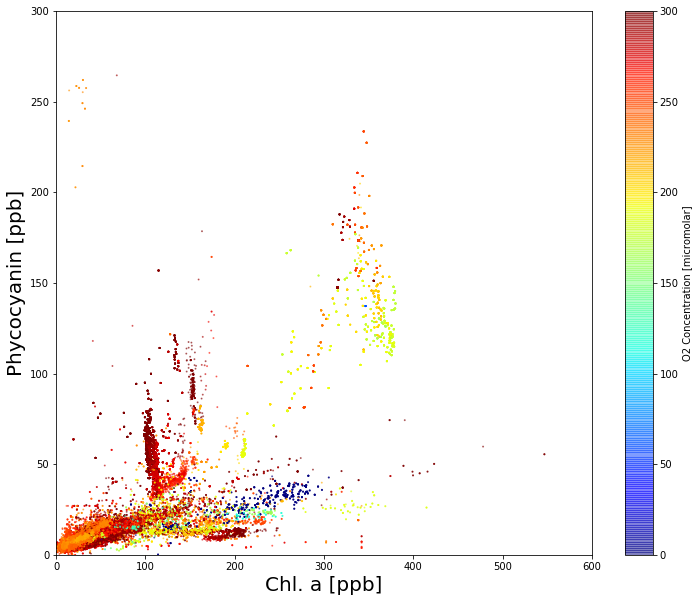

In [15]:
sailboat.plot(x_variable='chla', y_variable='phycocyanin',
             xlim=(0,600), ylim=(0,300), p_size=1, 
              show_z=True, z='o2 concentration', vmin=0, vmax=300)

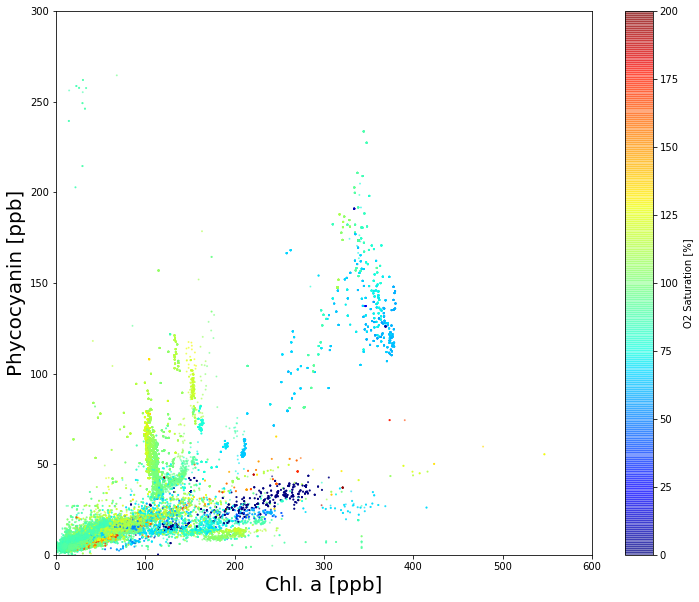

In [16]:
sailboat.plot(x_variable='chla', y_variable='phycocyanin',
             xlim=(0,600), ylim=(0,300), p_size=1, 
              show_z=True, z='o2 saturation', vmin=0, vmax=200)

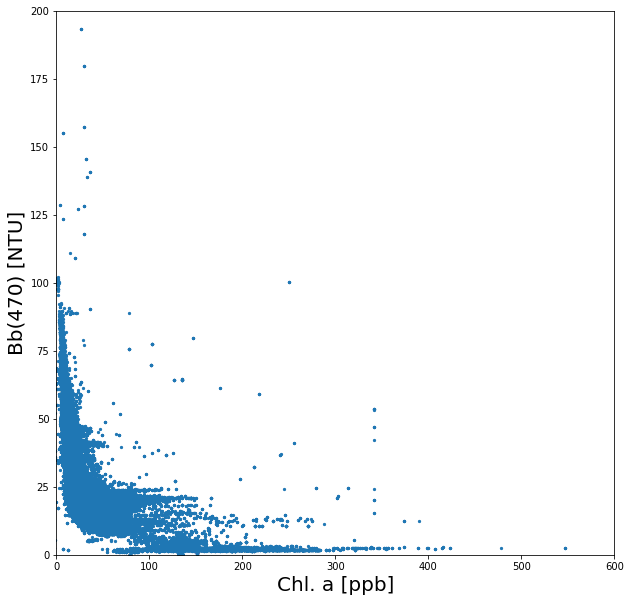

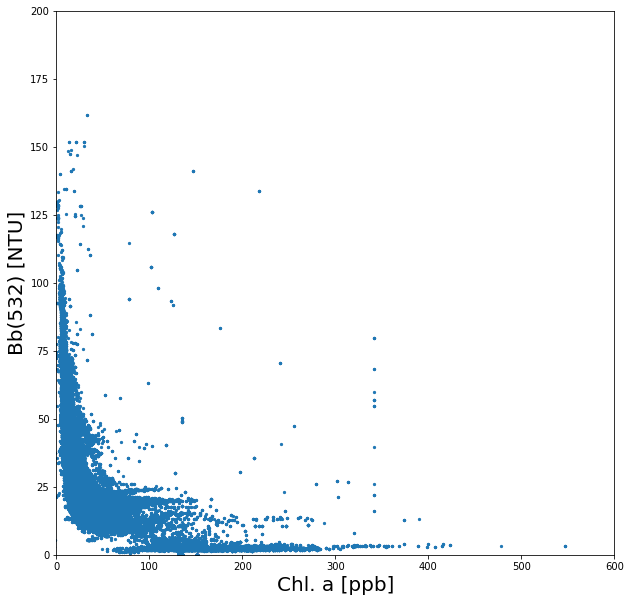

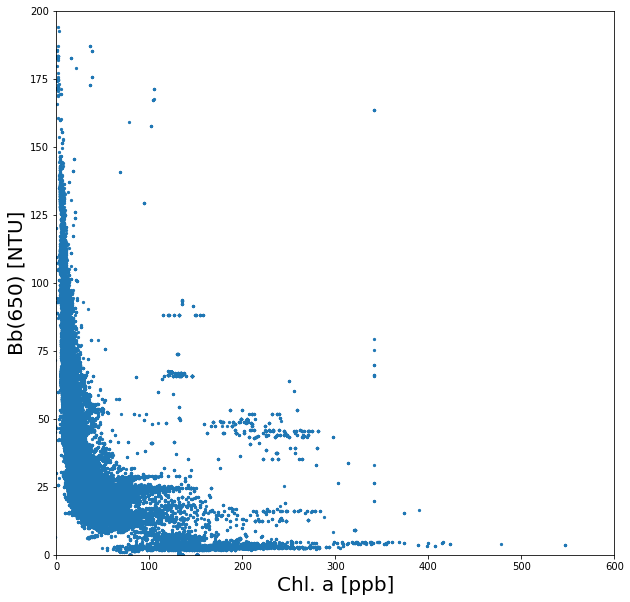

In [17]:
for bb in ['bb470', 'bb532', 'bb650']:
    sailboat.plot(x_variable='chla', y_variable=bb,
                 xlim=(0,600), ylim=(0,200), p_size=5)

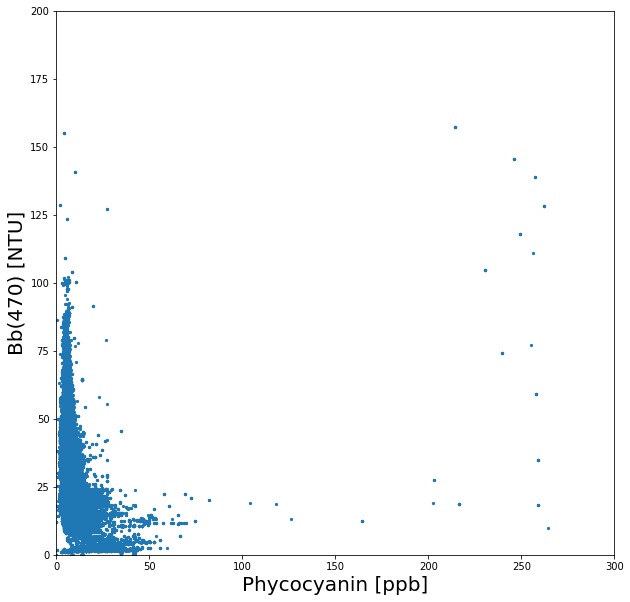

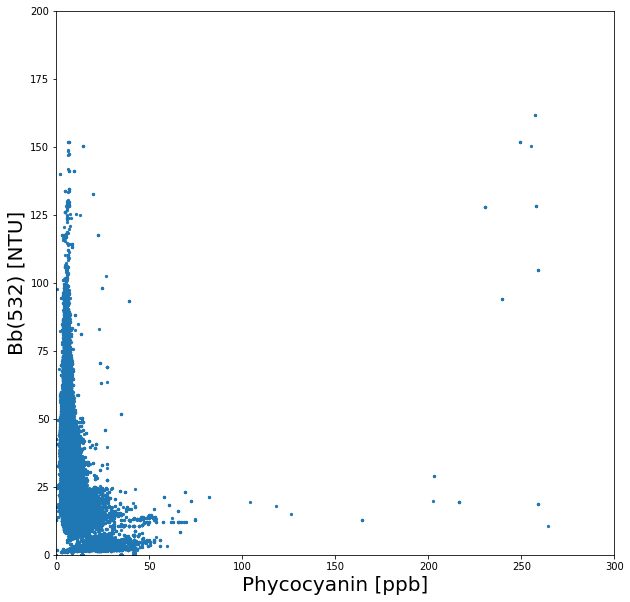

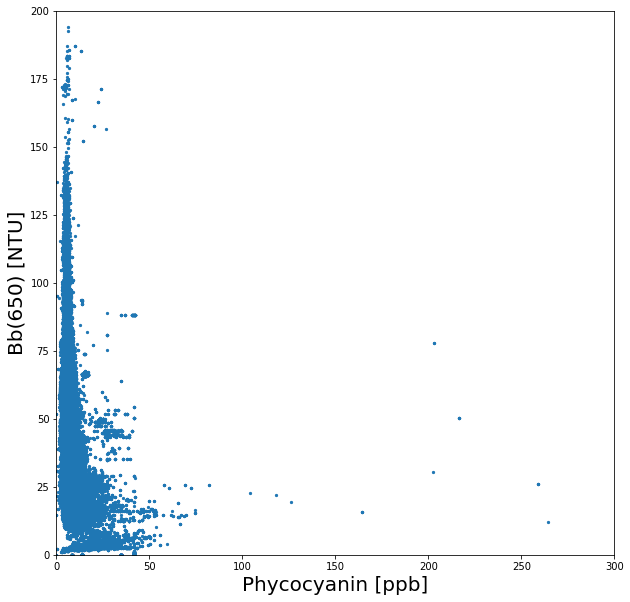

In [18]:
for bb in ['bb470', 'bb532', 'bb650']:
    sailboat.plot(x_variable='phycocyanin', y_variable=bb,
                 xlim=(0,300), ylim=(0,200), p_size=5)